# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 7c: Visualization of Filters and Feature Maps of CNNs</span> <span style="color:red">***</span> #
This is an **encourage-to-learn** knowledge since visualizing what is learned by CNNs is an important practical skill for taming and insightfully understanding the operation of CNNs. 

**The purpose of this tutorial is to assist you in mastering the techniques used to visualize filters and feature maps of CNNs. This skill is very crucial to understand insightfully how CNNs work and diagnose when your CNNs work and do not work. The following topics will be covered in this tutorial:**

I. Visualize the raw filters and feature maps of CNNs.

II. Visualize the filters of CNNs using activation maximization.

III. Visualize the filters of CNNs using activation maximization with the `tf-keras-vis` library.

**References and additional reading and resources**
- What do ConvNets see? Visualizing filters with Activation Maximization ([link](https://www.machinecurve.com/index.php/2019/12/03/what-do-convnets-see-visualizing-filters-with-activation-maximization/)).
- Visualize what ConvNets learn ([link](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb#scrollTo=y5MizItFKydg)).
- The Github of `tf-keras-vis` ([link](https://github.com/keisen/tf-keras-vis.git)).
- Tensorflow Keras pretrained models ([link](https://keras.io/api/applications/)).

---


## <span style="color:#0b486b">I. Visualize Filters and Feature Maps a Pretrained Network</span> ##

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import VGG19, ResNet101
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

In this part, we study how to visualize the raw filters and feature maps of CNNs. We demonstrate the pretrained `VGG19` model. We first load this model and list its all layers.

In [2]:
print("Loading network...")
vgg19 = VGG19(weights="imagenet", include_top=True, input_tensor = layers.Input(shape=(224,224,3)))
#resnet101 = ResNet101(weights="imagenet", include_top=True, input_tensor = layers.Input(shape=(224,224,3)))

layer_filters = {}
print("Showing layers...")
# loop over the layers in the network and display them to the console
for (i, layer) in enumerate(vgg19.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("{}\t{}\t{}\t{}".format(i, layer.__class__.__name__, layer.name, layer.get_weights()[0].shape))
        layer_filters[layer.name] = layer.get_weights()[0].shape[-1]
    else:
        print("{}\t{}\t{}".format(i, layer.__class__.__name__, layer.name))
# vgg19.summary()

Loading network...
Showing layers...
0	InputLayer	input_1
1	Conv2D	block1_conv1	(3, 3, 3, 64)
2	Conv2D	block1_conv2	(3, 3, 64, 64)
3	MaxPooling2D	block1_pool
4	Conv2D	block2_conv1	(3, 3, 64, 128)
5	Conv2D	block2_conv2	(3, 3, 128, 128)
6	MaxPooling2D	block2_pool
7	Conv2D	block3_conv1	(3, 3, 128, 256)
8	Conv2D	block3_conv2	(3, 3, 256, 256)
9	Conv2D	block3_conv3	(3, 3, 256, 256)
10	Conv2D	block3_conv4	(3, 3, 256, 256)
11	MaxPooling2D	block3_pool
12	Conv2D	block4_conv1	(3, 3, 256, 512)
13	Conv2D	block4_conv2	(3, 3, 512, 512)
14	Conv2D	block4_conv3	(3, 3, 512, 512)
15	Conv2D	block4_conv4	(3, 3, 512, 512)
16	MaxPooling2D	block4_pool
17	Conv2D	block5_conv1	(3, 3, 512, 512)
18	Conv2D	block5_conv2	(3, 3, 512, 512)
19	Conv2D	block5_conv3	(3, 3, 512, 512)
20	Conv2D	block5_conv4	(3, 3, 512, 512)
21	MaxPooling2D	block5_pool
22	Flatten	flatten
23	Dense	fc1
24	Dense	fc2
25	Dense	predictions


In what follows, we load an image from the hard disk and predict the label of this image using the pretrained VGG19 model. As shown below, the pretrained model can predict the image of a cat correctly because it offers the predicted label `Siamese_cat`.

Predicted: [('n02123597', 'Siamese_cat', 0.900439), ('n02124075', 'Egyptian_cat', 0.019448629), ('n03223299', 'doormat', 0.016098035)]


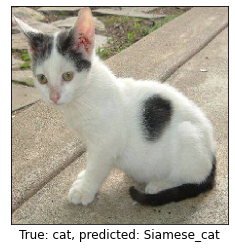

In [3]:
img_path = './imgs/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x_raw = image.img_to_array(img)
x = np.expand_dims(x_raw, axis=0)
x_copy = x.copy()
x = preprocess_input(x)
preds = vgg19.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
plt.imshow(img)
plt.xlabel("True: cat, predicted: {}".format(decode_predictions(preds, top=3)[0][0][1]), fontsize= 12)
plt.xticks([])
plt.yticks([])
plt.grid(False)

The following function helps us to visualize the feature maps at a given layer of a given input image.

In [4]:
def visualize_feature_maps(input_img=None, model=None, layer_name=None, n_cols=8):
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_model.predict(input_img) # 4D tensor [batch_size, in_height, in_width, in_depth=num_feature_maps]
    n_feature_maps = intermediate_output.shape[-1] # get num_feature_maps
    n_images = math.floor(n_feature_maps/4) + 1 # display num_feature_maps/4 feature maps and original images
    n_rows = math.ceil(n_images/n_cols)
    fig = plt.figure(figsize=(n_cols*3, n_rows*3))
    plt.axis("off")
    for i in range(n_images):
        plt.subplot(n_rows, n_cols, i+1)
        img = np.squeeze(input_img)/255.0 if i==0 else intermediate_output[0,:,:, i-1]
        label = "Input image" if i==0 else "{} of {}".format(i, n_feature_maps)
        if i==0:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap= "gray")
    
        plt.xlabel(label, fontsize= 10)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

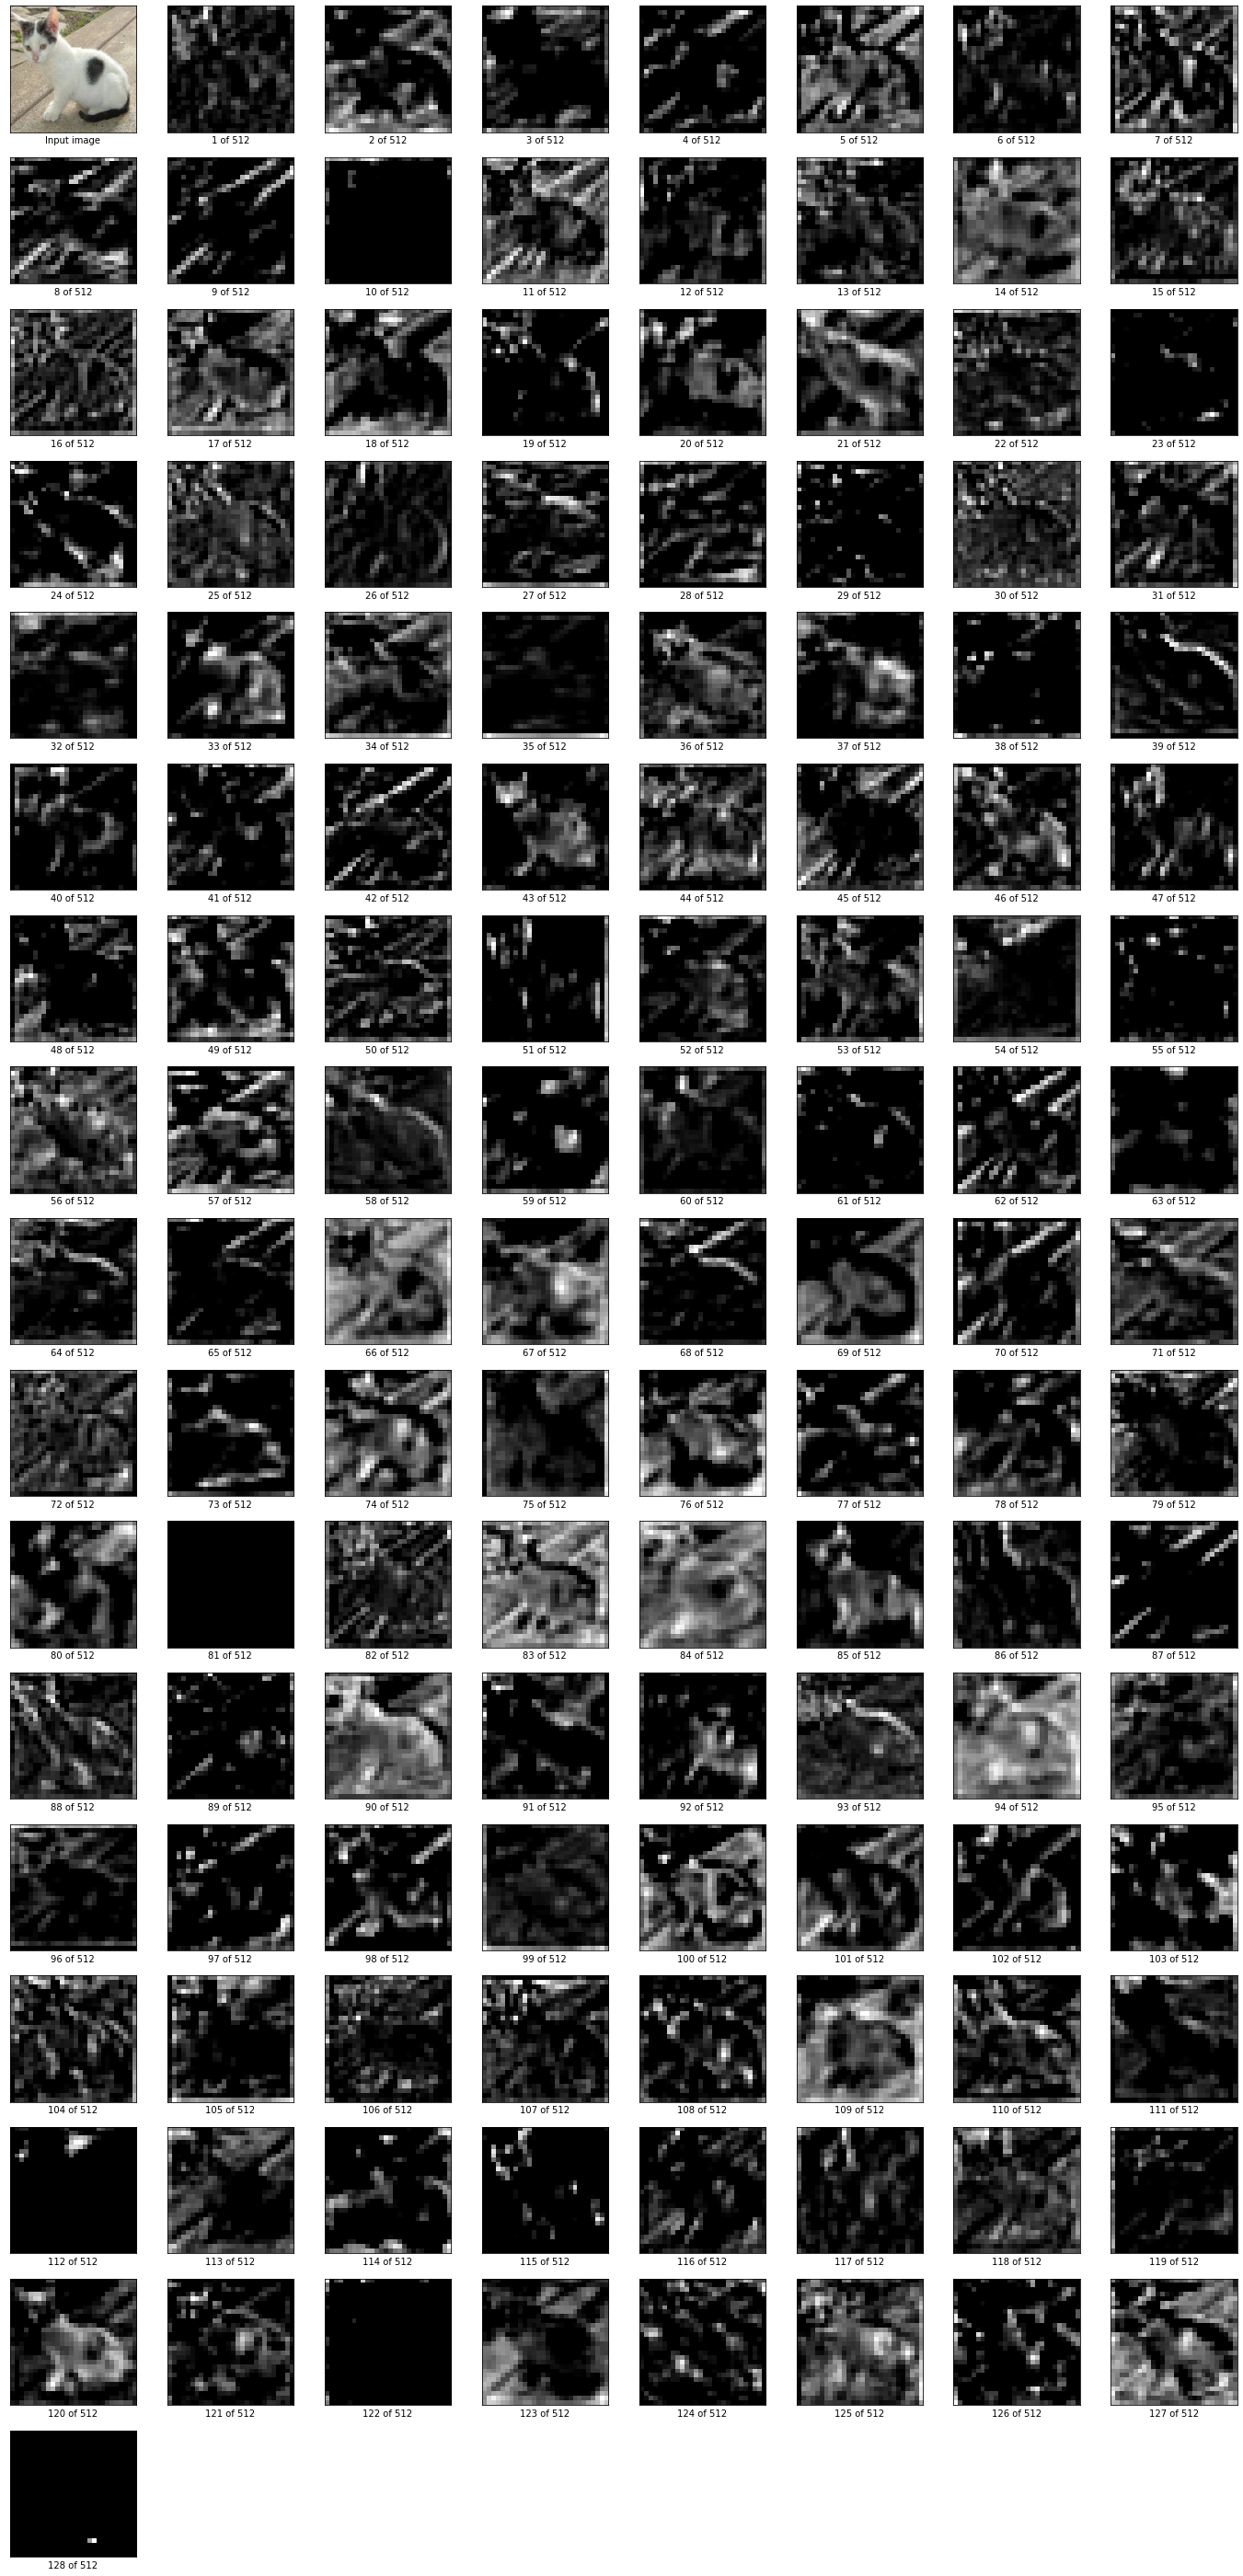

In [5]:
visualize_feature_maps(x_copy, vgg19, "block4_conv1")

As you can observe, it seems that each feature map preserves some characteristic features in the input image. You can do further investigations by visualizing feature maps of low-level, mid-level, and high-level feature maps and draw your own conclusions. 

The following function supports us in visualizing the raw filters in a Conv2D layer in a CNN.

In [6]:
def visualize_filter(model, layer_name= None, n_cols = 8):
    layer = model.get_layer(layer_name)
    assert isinstance(layer, tf.keras.layers.Conv2D), "The current layer is not a Conv2D layer"
    filters = layer.get_weights()[0]  #4D tensor of all filters [fil_height, fil_width, fil_depth, num_filters = out_channels]
    n_filters = filters.shape[-1]    #get the number of filters to later visualize each of them
    n_rows = math.ceil(n_filters/n_cols)
    fig = plt.figure(figsize=(n_cols*1, n_rows*1))
    plt.axis("off")
    for i in range(n_filters):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(np.clip(filters[:,:,:,i], 0, 255)) 
        plt.xlabel("Filte {}".format(i))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    fig.tight_layout()

Here we visualize all filters of the first CONV2D layer of VGG19.

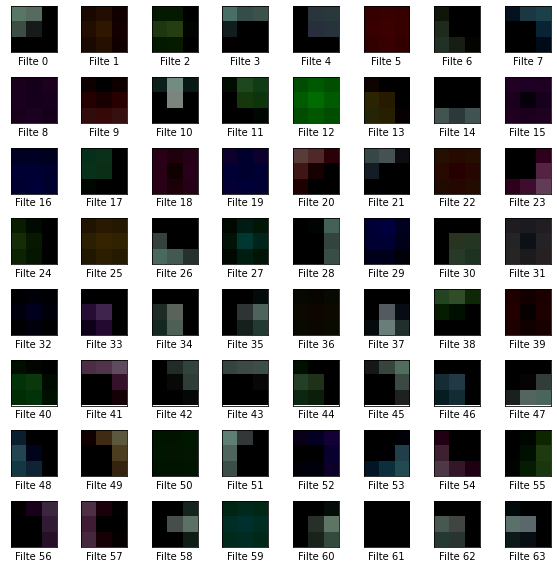

In [7]:
visualize_filter(vgg19, "block1_conv1", n_cols= 8)

For higher layers, it is hard to base on the raw filters to justify what was learned at a Conv2D layer. The reason is that those filters are tiny filters of the shape $[3 \times 3]$. To obtain a better and meaningful visualization, we need to invoke the `activation maximization` technique which will be presented in the following part.

## <span style="color:#0b486b">II. Visualize CNN with Activation Maps</span> ##

The core idea of the activation maximization technique for visualizing a specific filter at a Conv2D layer is to choose the input image that can maximize the feature (activation) map corresponding to the filter. 
- We initialize the input image randomly.
- We feed the input image to a CNN and consider the activation (feature) map corresponding to the filter we need to visualize.
- We take the average of neurons on this feature (activation) map and update the input image using gradient descent for maximizing that average.

### <span style="color:#0b486b">II.1. Manual Implementation</span> ###

The following code shows how to initialize the input image.

In [8]:
def initialize_image(img_width, img_height):
    # We start from a gray image with some random noise
    img = tf.random.normal((1, img_width, img_height, 3), mean=127.5, stddev=0.05*255)
    return img

In what follows, we use gradient descent to update the input image in many iterations. Note that as specified in the following section, we define the loss function as the sum of the negative average neurons and the sparsity term on the input image. By this means, we desire to find the sparse input image that can activate the filter of interest, meaning that finding the patterns that can activate the corresponding filter.

In [9]:
def visualize_filter_activation(model, layer_name= 'None', filter_index= 1, iterations= 50, learning_rate= 10, alpha= 10):
    img = initialize_image(224, 224)
    #intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)    
    for iteration in range(iterations):
        loss, img = gradient_descent_step(img, model, layer_name, filter_index, learning_rate, alpha)
        
    # Decode the resulting input image
    shown_img = np.clip(img[0].numpy(), 0, 255).astype('uint8') 
    plt.imshow(shown_img, interpolation='nearest')

We compute the loss as the negative average of the neurons over the feature map obtained by feeding the input image to the Conv2D layer. 

In [10]:
@tf.autograph.experimental.do_not_convert
def compute_loss(img, model, layer_name, filter_index):
    mid_layer =  model.get_layer(layer_name)
    h = img
    for i in range(len(model.layers)):
        cur_layer = model.layers[i]
        h = cur_layer(h)
        if cur_layer == mid_layer:
            break
    #filter_output = intermediate_model.predict(img, steps=1) #, verbose=1, steps=1 tf.convert_to_tensor(img, dtype= tf.float32), steps=1
    filter_activation = h[:, :, :, filter_index]
    loss = -tf.reduce_mean(filter_activation)
    return loss

We compute the regularization term as a norm over the input image to encourage sparse input images.

In [11]:
@tf.autograph.experimental.do_not_convert
def compute_regulizer(img, p=10):
    reg = tf.norm(tensor=img, ord=p)*1.0/(np.prod(img.shape[1:]))
    return reg

The following TF function assists us in computing the gradient of the loss function w.r.t the input image and updating the input image via gradient descent. Note that the final loss consists of two terms as aforementioned.

In [12]:
@tf.function
def gradient_descent_step(img, model, layer_name, filter_index, learning_rate, alpha=10):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, model, layer_name, filter_index) + alpha*compute_regulizer(img, p=10)
    grads = tape.gradient(loss, img)  # Compute gradients.
    grads = tf.math.l2_normalize(grads)  # Normalize gradients.
    img -= learning_rate * grads  #Gradient descent
    return loss, img

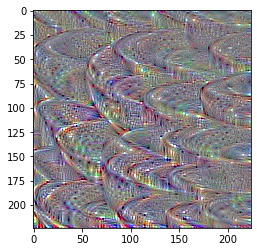

In [13]:
visualize_filter_activation(vgg19, "block5_conv2", learning_rate=100, filter_index=453, iterations=200, alpha=100)

**<span style="color:red">Exercise 1</span>**: Extend the following code to find the input image that can maximize the prediction of a given class. This input image can be regarded as a typical input image of that class.

*Hint: Consider the output layer to define the corresponding loss function.*

In [14]:
@tf.autograph.experimental.do_not_convert
def initialize_image(img_width, img_height):
    # We start from a gray image with some random noise
    img = tf.random.normal((1, img_width, img_height, 3), mean=127.5, stddev=0.05*255)
    return img

In [15]:
@tf.autograph.experimental.do_not_convert
def compute_loss(img, model, class_index=0):
    h = img
    for i in range(len(model.layers)):
        cur_layer = model.layers[i]
        h = cur_layer(h)
    loss = -tf.reduce_mean(tf.math.log(h[:,class_index]+ 1E-5))
    return loss

In [16]:
@tf.autograph.experimental.do_not_convert
def compute_regulizer(img, p=10):
    reg = tf.norm(tensor=img, ord=p)*1.0/(np.prod(img.shape[1:]))
    return reg

In [17]:
@tf.function
def gradient_descent_step(img, model, class_index=0, learning_rate=100, alpha=10):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, model, class_index) + alpha*compute_regulizer(img, p=10)
    grads = tape.gradient(loss, img)  # Compute gradients.
    grads = tf.math.l2_normalize(grads)  # Normalize gradients.
    img -= learning_rate * grads  # Gradient descent
    return loss, img

In [18]:
def visualize_class_activation(model, class_index=0, iterations=50, learning_rate=10, alpha=10):
    img = initialize_image(224, 224)
    #intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)    
    for iteration in range(iterations):
        loss, img = gradient_descent_step(img, model, class_index, learning_rate, alpha)
        if (iteration + 1) % 50 == 0:
            print('iter {}/{} loss {}'.format(iteration + 1, iterations, loss))
        
    # Decode the resulting input image
    shown_img = np.clip(img[0].numpy(), 0, 255).astype('uint8') 
    plt.imshow(shown_img, interpolation='nearest')
    return shown_img

iter 50/200 loss 0.027995135635137558
iter 100/200 loss 0.025989925488829613
iter 150/200 loss 0.024221928790211678
iter 200/200 loss 0.022550875321030617


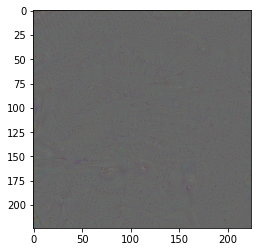

In [19]:
shown_img = visualize_class_activation(vgg19, class_index=0, iterations=200, learning_rate=100, alpha=10)

In [20]:
shown_img = np.expand_dims(shown_img, axis=0)
print(shown_img.shape)

(1, 224, 224, 3)


In [21]:
preds = vgg19.predict(shown_img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01440764', 'tench', 0.9999982), ('n02514041', 'barracouta', 1.1246528e-06), ('n02074367', 'dugong', 2.9046288e-07)]


### <span style="color:#0b486b">II.2. Using tf-keras-vis</span> ###

#### <span style="color:#0b486b">II.2.1 Installing tf-keras-vis</span> ####

`tf-keras-vis` can be installed with `pip` as follow:
>pip install tf-keras-vis

#### <span style="color:#0b486b">II.2.2 Filter visualization</span> ####

We import VGG19 model and neccesary classes of `tf-keras-vis` to invoke the `activation maximization` technique.

In [23]:
from tensorflow.keras.applications import VGG19
from matplotlib import pyplot as plt
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import tensorflow as tf
import numpy as np

50/50 [==============================] - 6s 122ms/step - Score: 213.1500 - TotalVariation2D: 9.7666 - Norm: 40.8547


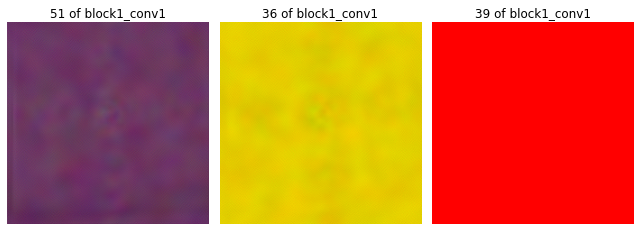

50/50 [==============================] - 25s 500ms/step - Score: 989.9684 - TotalVariation2D: 47.6484 - Norm: 46.7245


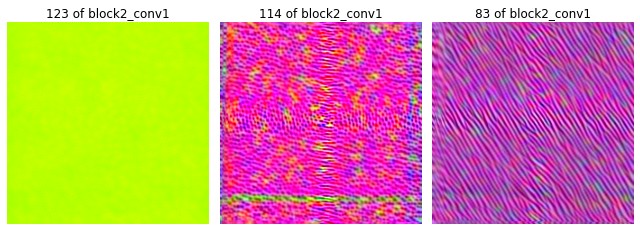

50/50 [==============================] - 42s 839ms/step - Score: 1944.1649 - TotalVariation2D: 52.7026 - Norm: 40.6995


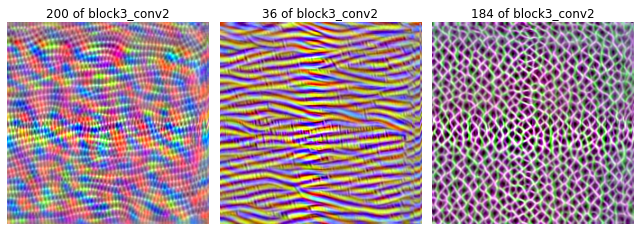

50/50 [==============================] - 57s 1s/step - Score: 16926.8047 - TotalVariation2D: 50.9573 - Norm: 41.5583


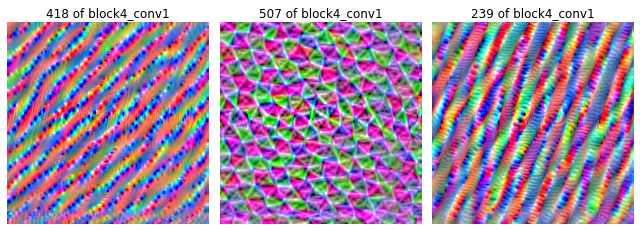

50/50 [==============================] - 78s 2s/step - Score: 2146.2222 - TotalVariation2D: 36.3366 - Norm: 39.5853


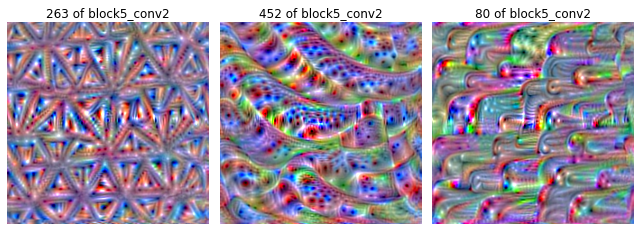

In [24]:
layer_list = ['block1_conv1', 'block2_conv1', 'block3_conv2', 'block4_conv1', 'block5_conv2']

# Define seed inputs whose shape is (samples, height, width, channels).
seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

for layer_name in layer_list:
    # Draw 3 filters randomly
    drawn_filters = np.random.choice(np.arange(layer_filters[layer_name]), size=3).tolist()
    
    # Declare a score function that collects the scores from model output
    scores = CategoricalScore(drawn_filters)
    
    # Use class ExtractIntermediateLayer to build a new model instance whose output layer is an intermediate layer of model. 
    # Next, we replace the activation functions of all output layers to tf.keras.activations.linear using ReplaceToLinear. 
    activation_maximization = \
       ActivationMaximization(VGG19(), model_modifier=[ExtractIntermediateLayer(layer_name), ReplaceToLinear()])
    
    activations = \
       activation_maximization(scores,
                               steps=50,
                               seed_input=seed_input,
                               # TotalVariation2D is a regularizer that uses tf.image.total_variation(...) for image denoising.
                               regularizers=[TotalVariation2D(weight=1.0), Norm(weight=0.3, p=1)],
                               optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
                               callbacks=[Progress()])
    
    # Visualize filters from drawn_filters
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 4)) 
    for i, filter_id in enumerate(drawn_filters):
        ax[i].set_title('{} of {}'.format(filter_id, layer_name), fontsize=12)
        ax[i].imshow(activations[i])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>